SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #5: TS Foreasting using ARIMA Models </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - stationary TS, ARMA, ARIMA, ARMAX, SARIMAX, autocorrelcation function,  partial autocorrelation function, exogenious variables,
**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from copy import deepcopy

# don't forget to upload utils file to the colab session
from utils import qualityMACAPE, qualityRMSE
import warnings
warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

# ARIMA Parameters
**Questions**
  * How to make TS stationary?
  * Write down formula that describes how the tranformed ts will look like (use lag operator $\bf B$).

**Answer**
$${\bf(1-B)^d(1-B^s)^D} {\bf BoxCox_{\lambda}} (y_t)$$
where $s~-$ seasonality period


 




## ARIMA model for non-stationary time series
In order to make ts stationary we apply trend ${\bf(1-\bf B)}$ differencing $d$ times and seasonal ${\bf(1-B^s)}$ differencing $D$ times.


**Main hypothesys**: exists $d$, $D$, $\lambda$ such that
  
  * $$ {\bf(1-B)^d(1-B^s)^D} {\bf BoxCox_{\lambda}} (y_t)~- \text{ stationary} $$ 


Final ts model:
* Lets denote: ${\bf BoxCox_{\lambda}} (y_t) = z_t$
* classic form:
$$\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}z_t = \underbrace{c+\sum_{i=1}^{p} \alpha_iz_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\varepsilon_t$$

* or in canonical form:

$$\underbrace{\phi\left({\bf B}\right)}\limits_{AR}\color{red}{\underbrace{\bf(1-B)^d(1-B^s)^D}\limits_{I}}(z_t-\mu) = \underbrace{\theta\left(\bf B\right)}\limits_{MA}\varepsilon_t.$$

* $\varepsilon_t$- random variable from $N(0, \sigma^2)$, $E\varepsilon_t=0, ~E\varepsilon_i\varepsilon_j=0$

# Fitting Parameters of ARIMA model

Classic form of ARIMA model implies that there are some seasonal Autoregressive Components and seasonal Moving Average Components


$${\bf(1-B)^{\color{red}{d}}(1-B^s)^{\color{red}D}}z_t = \underbrace{c+\sum_{i=1}^{\color{red}p} \alpha_iz_{t-i}}\limits_{AR}+\underbrace{\sum_{j=1}^{\color{red}q} \beta_j\varepsilon_{t-j}}\limits_{MA}+\underbrace{\sum_{l=1}^{\color{red}P} \delta_lz_{t-\color{red}{s\cdot l}}}\limits_{seasonal~AR}+\underbrace{\sum_{m=1}^{\color{red}Q} \omega_m\varepsilon_{t-\color{red}{s*m}}}\limits_{seasonal~MA}+\varepsilon_t$$


Classic ARIMA model contains 6 (hyper)parameters:
$$ARIMA(p, d, q)\times(P, D, Q)_s$$
where

 - $p~-$ is a number of non-seasonal AR components
 - $q~-$ is a number of non-seasonal MA components
 - $d~-$ is a number of trend-differencing applied to make ts stationary
 - $P~-$ is a number of seasonal AR components
 - $Q~-$ is a number of seasonal MA components
 - $D~-$ is a number of seasonal-differencing to make ts stationary

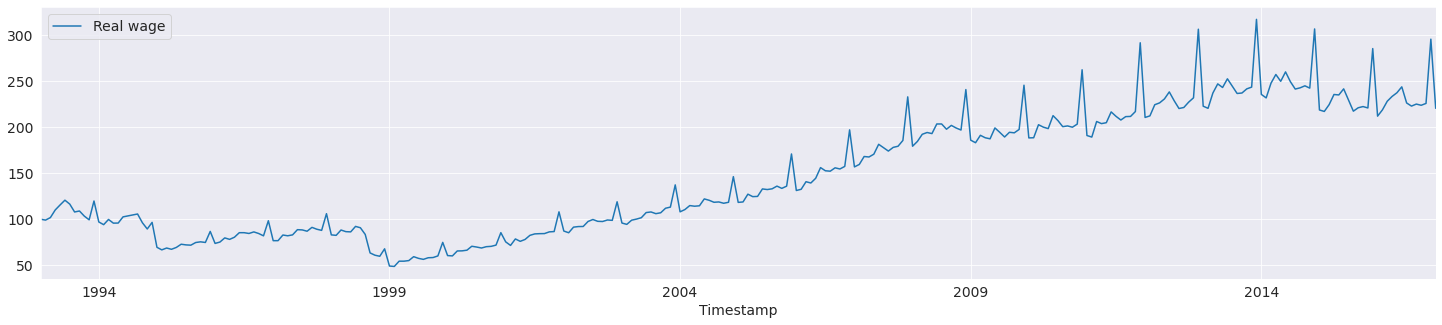

In [ ]:
# Wage
ts_wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/33b78c9be63831567f8036ad40c5859e824d30f7/data/monthly-wage.csv', sep=';', decimal='.', parse_dates=True, index_col='Month')
ts_wage.index.names=['Timestamp']
ts_wage.plot()

## Fitting of $\lambda$, $d$, $D$ parameters

optimal lambda: 0.12682613030318318
The KPSS test statistic 0.031104, 
pvalue: 0.10 
maximal Lag: 16 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The Augmented Dickey-Fuller test statistic -4.434243, 
pvalue: 0.00 
maximal Lag: 15 
critical values: {'1%': -3.4557539868570775, '5%': -2.8727214497041422, '10%': -2.572728476331361}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


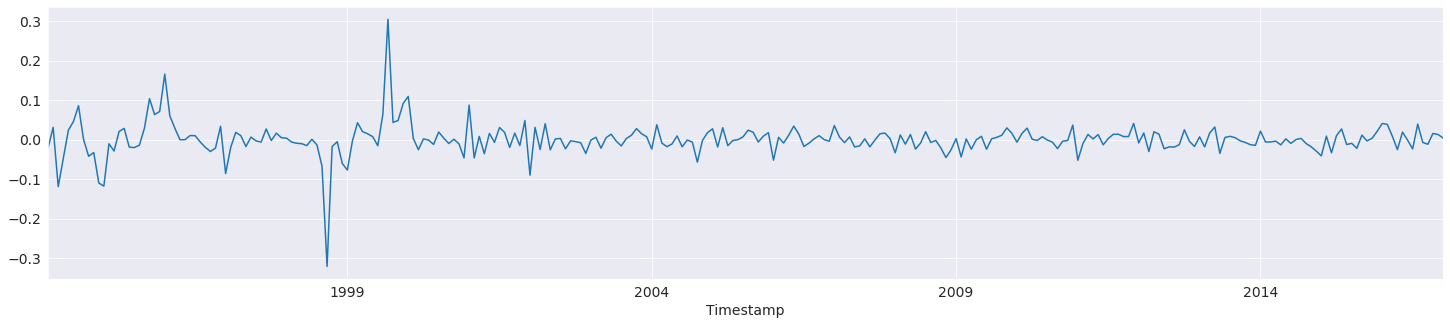

In [ ]:
ts_wage_boxcox = deepcopy(ts_wage)
# find optimal lambda 
print('optimal lambda:', stats.boxcox(ts_wage['Real wage'])[1])

# Box_Cox transformation (see lesson 4 for details)
ts_wage_boxcox['wage_boxcox'] = np.log(ts_wage)
# ts_wage_boxcox['wage_boxcox'].plot()


# seasonal differencing
p = 12
sdiff_ts_wage_boxcox = (ts_wage_boxcox['wage_boxcox'] - ts_wage_boxcox['wage_boxcox'].shift(p))[p:]
# sdiff_ts_wage_boxcox.plot()

# trend differencing
diff_sdiff_ts_wage_boxcox = (sdiff_ts_wage_boxcox  - sdiff_ts_wage_boxcox .shift(1))[1:]
diff_sdiff_ts_wage_boxcox.plot()

# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(np.array(diff_sdiff_ts_wage_boxcox))
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

# Augmented Dickey-Fuller unit root test
df_stat = stattools.adfuller(np.array(diff_sdiff_ts_wage_boxcox))
print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ncritical values: %s' % 
      (df_stat[0], df_stat[1], df_stat[2], df_stat[4]))


In [ ]:
# Let's train our first ARMA(p,q) model
arma_mod00 = sm.tsa.ARMA(diff_sdiff_ts_wage_boxcox, (0,0)).fit()
print(arma_mod00.summary())
# print(arma_mod00.aic, arma_mod00.bic, arma_mod00.hqic)


                              ARMA Model Results                              
Dep. Variable:            wage_boxcox   No. Observations:                  276
Model:                     ARMA(0, 0)   Log Likelihood                 490.277
Method:                           css   S.D. of innovations              0.041
Date:                Sat, 02 Oct 2021   AIC                           -976.554
Time:                        11:38:59   BIC                           -969.313
Sample:                    02-01-1994   HQIC                          -973.648
                         - 01-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.103      0.918      -0.005       0.005


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


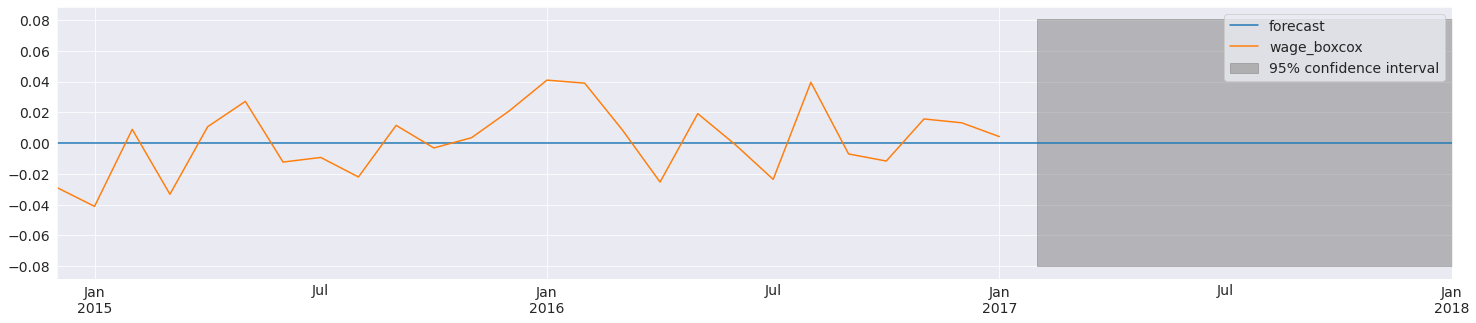

In [ ]:
frc_arma = arma_mod00.predict('2014-12-01', '2017-12-01', dynamic=False)
# fig, ax = plt.subplots(figsize=(15,5),  linewidth=3.0)
fig = arma_mod00.plot_predict(start='2014-12-01', end='2018-01-01')
# print(frc_arma)

**Questions**
  * What should be done to forecast original wage ts?

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        wage_boxcox   No. Observations:                  289
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 490.272
Date:                            Sat, 02 Oct 2021   AIC                           -978.543
Time:                                    11:43:11   BIC                           -974.923
Sample:                                01-01-1993   HQIC                          -977.090
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0017   3.91e-05     42.883      0.000       0.002       0.002
Ljung-Box (Q):                     

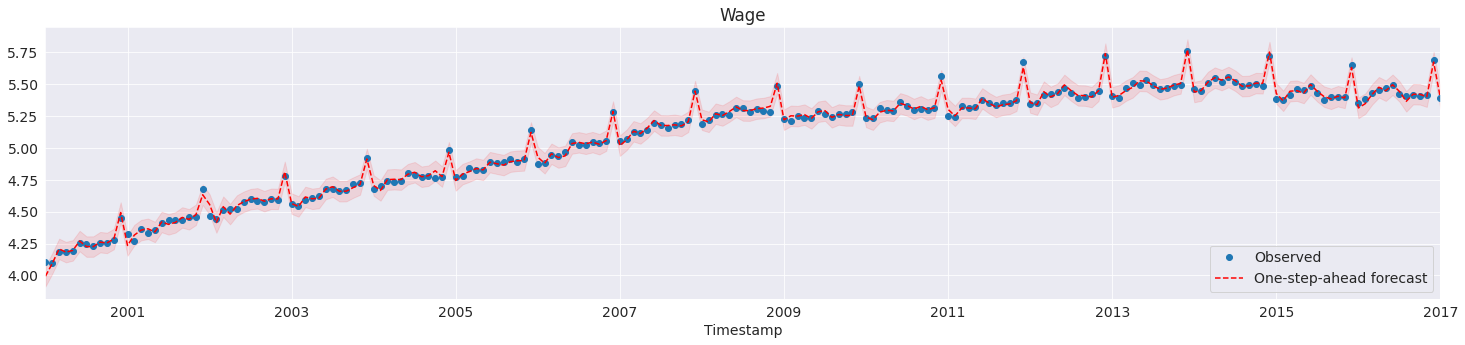

In [ ]:
# Let's train our first ARIMA (p, d, q)x(P, D, Q, s) model
arima_010_010 = sm.tsa.SARIMAX(endog = ts_wage_boxcox['wage_boxcox'], order=(0, 1, 0), seasonal_order = (0,1,0,12)).fit()
print(arima_010_010.summary())


predict = arima_010_010.get_prediction()
predict_ci = predict.conf_int() # confidence interval


start_dt = '2000-01-01'

#  Dynamic predictions
# predict_dy = arima_010_010.get_prediction(dynamic=start_dt)
# predict_dy_ci = predict_dy.conf_int() # confidence interval

# Graph
fig, ax = plt.subplots()
npre = 4
ax.set(title='Wage', xlabel='Date')

# Plot data points
ts_wage_boxcox.loc[start_dt:, 'wage_boxcox'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean[start_dt:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc[start_dt:]
ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='r', alpha=0.1)
# predict_dy.predicted_mean.loc[start_dt:].plot(ax=ax, style='g', label='Dynamic forecast 2014-01')
# ci = predict_dy_ci.loc[start_dt:]
# ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='g', alpha=0.1)
legend = ax.legend(loc='lower right')

## Fitting of $q$, $Q$ and $p$, $P$ parameters

  
**Autocorrelation coeficient:**
*  $$ r_\tau = r_{y_t y_{t+\tau}} = \frac{\sum\limits_{t=1}^{T-\tau} \left(y_t - \bar{y}\right)\left(y_{t+\tau} - \bar{y}\right) }{ \sum\limits_{t=1}^T \left(y_t - \bar{y}\right)^2 },\;\; \bar{y} = \frac1{T} \sum_{t=1}^T y_t.$$
		
$r_\tau \in\left[-1,1\right], \;\; \tau$ - autocorrelation lag.




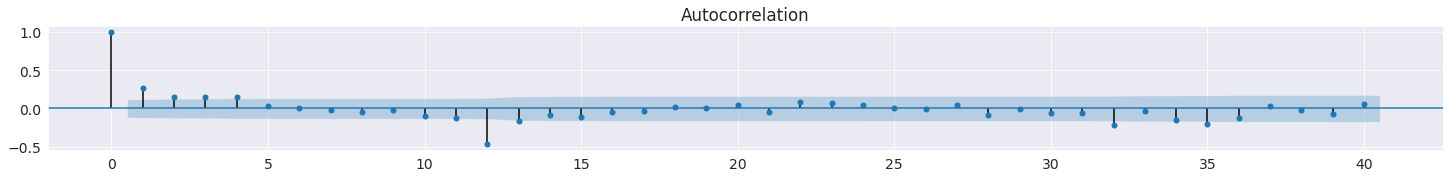

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_sdiff_ts_wage_boxcox, lags=40, ax = ax1)

**Coefficient of partial correlation:** between $y$, $x_1$ excluding dependence on $x_2$:
<img src='https://github.com/aromanenko/ATSF/blob/main/pic/PACF.PNG?raw=1'>

* <font color="red">Coefficient of partial correlation</font> shows correlation between $y_t$ and $y_{t+\tau}$, <font color=""> excluding dependence </font>
   - between $y_t$ and $y_{t+1}$ ($y_{t+\tau}$ and $y_{t+1}$)  
   - between $y_t$ and $y_{t+2}$ ($y_{t+\tau}$ and $y_{t+2}$)
   
   ...
   
   - between $y_t$ and $y_{t+\tau-1}$ ($y_{t+\tau}$ and $y_{t+\tau-1}$)


*  see here  <a href="https://timeseriesreasoning.com/contents/partial-auto-correlation"> here </a> for details

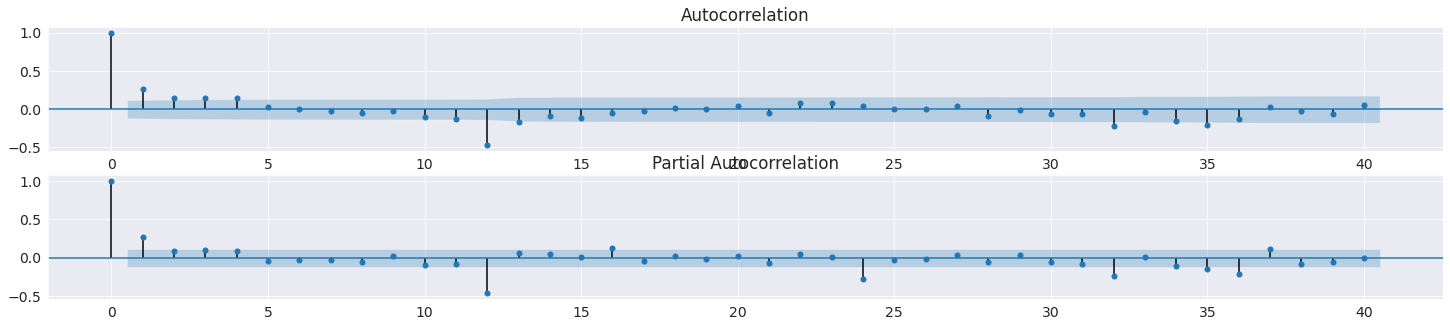

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff_sdiff_ts_wage_boxcox, lags=40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff_sdiff_ts_wage_boxcox, lags=40, ax=ax2)

**How to select candidates for $q$ and $Q$ based on ACF?**

*Answer*: 
* $q$: the number of the last lag $\tau<S$ at which <span style="color:red"> ACF </span> was significant ($S$ - period of seasonality)
* $Q$: the lag numbers $\tau= s*m$ that are multiples of the seasonality period $s$: at which <span style="color:red"> ACF </span> was significant

**How to select candidates for $p$ and $P$ based on PACF?**

*Answer*: 

* $p$: the number of the last lag $\tau<S$ at which <span style="color:red">PACF</span> was significant at which <span style="color:red"> PACF </span> was significant
* $P$: he lag numbers $\tau= s*m$ that are multiples of the seasonality period at which <span style="color:red">PACF</span> was significant at which <span style="color:red"> PACF </span> was significant


**Question**:
* Provide candidates for $q, Q, p, P$ values in case of the wage_ts 
  * $q$ = {1, 2, 3, 4}
  * $Q$ = {1}
  * $p$ = {1}
  * $P$ = {1, 2, 3}

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:            wage_boxcox   No. Observations:                  276
Model:                     ARMA(1, 1)   Log Likelihood                 502.552
Method:                       css-mle   S.D. of innovations              0.039
Date:                Sat, 02 Oct 2021   AIC                           -997.104
Time:                        11:48:45   BIC                           -982.622
Sample:                    02-01-1994   HQIC                          -991.293
                         - 01-01-2017                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0002      0.004      0.050      0.960      -0.008       0.008
ar.L1.wage_boxcox     0.6798      0.123      5.509      0.000       0.438       0.922
ma.L1.wage_boxcox    -0.

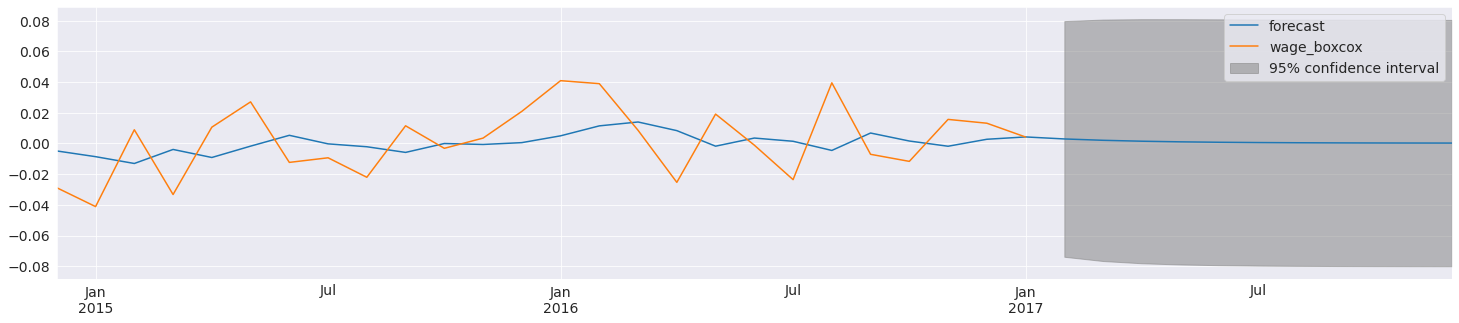

In [ ]:
# Let's train the second ARMA model
arma_mod11 = sm.tsa.ARMA(diff_sdiff_ts_wage_boxcox, (1,1)).fit()
print(arma_mod11.summary())
frc_arma = arma_mod11.predict('2014-12-01', '2017-12-01', dynamic=False)
fig, ax = plt.subplots()
fig = arma_mod11.plot_predict(start='2014-12-01', end='2017-12-01', ax=ax)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        wage_boxcox   No. Observations:                  289
Model:             SARIMAX(0, 1, 1)x(3, 1, 1, 12)   Log Likelihood                 555.495
Date:                            Sat, 02 Oct 2021   AIC                          -1098.991
Time:                                    11:51:00   BIC                          -1077.268
Sample:                                01-01-1993   HQIC                         -1090.274
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1678      0.049      3.427      0.001       0.072       0.264
ar.S.L12      -0.3036      0.182   

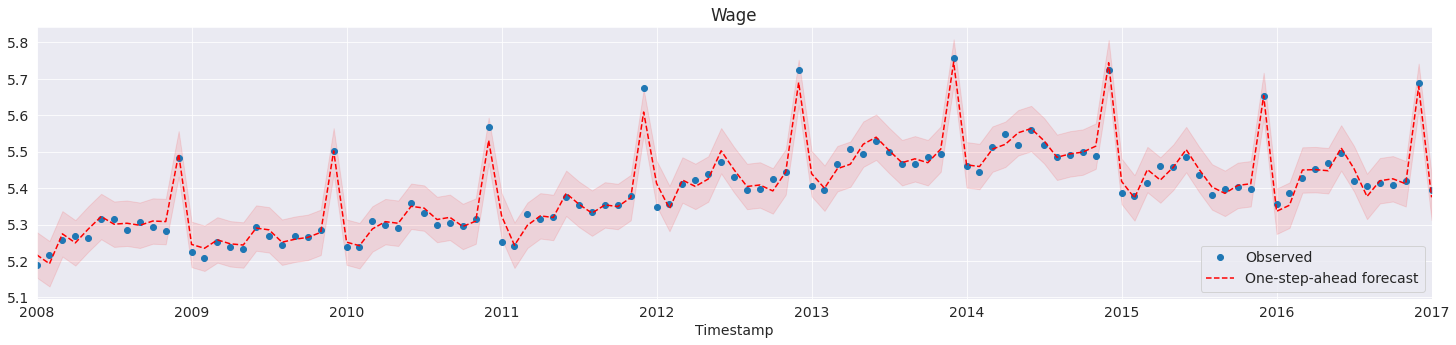

In [ ]:
# Let's train the second ARIMA(p,d,q)x(P, D, Q) model 
arima_011_311 = sm.tsa.SARIMAX(endog = ts_wage_boxcox['wage_boxcox'], order=(0, 1, 1), seasonal_order = (3,1,1,12)).fit()
print(arima_011_311.summary())


predict = arima_011_311.get_prediction()
predict_ci = predict.conf_int() # confidence interval


start_dt = '2008-01-01'

#  Dynamic predictions
# predict_dy = arima_010_010.get_prediction(dynamic=start_dt)
# predict_dy_ci = predict_dy.conf_int() # confidence interval

# Graph
fig, ax = plt.subplots()
npre = 4
ax.set(title='Wage', xlabel='Date')

# Plot data points
ts_wage_boxcox.loc[start_dt:, 'wage_boxcox'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean[start_dt:].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc[start_dt:]
ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='r', alpha=0.1)
# predict_dy.predicted_mean.loc[start_dt:].plot(ax=ax, style='g', label='Dynamic forecast 2014-01')
# ci = predict_dy_ci.loc[start_dt:]
# ax.fill_between(ci.index, ci.loc[:,ci.columns[0]], ci.loc[:,ci.columns[1]], color='g', alpha=0.1)
legend = ax.legend(loc='lower right')

**What else can be done?**
## Residuals Analysis
**Questions**:
* How to check all assumptions around ARIMA model?
  - Unbiasedness ($\mathbf{E}\varepsilon_t = 0$): Wilcoxon or Student.
  - No autocorrelation in residuals ($\mathbf{E}\varepsilon_t \varepsilon_{t+\tau} = 0$): correlogram analysis, Ljung-Box Q-test, Durbin-Watson.
  - Normality ($\varepsilon_t \in N(0, \sigma)$): q-q plot, Shapiro-Wilk test.
  - Stationarity ($\varepsilon_t$ belong to the same distibution $\forall t$)  visual analysis, KPSS, Dickey-Fuller.
 

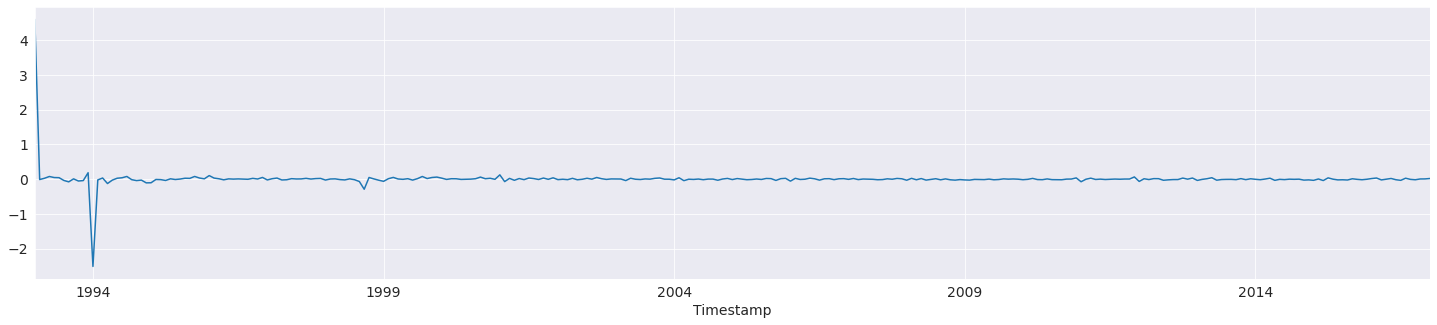

In [ ]:
# plot residuals
fig = plt.figure()
ax = fig.add_subplot(111)
ax = arima_011_311.resid.plot(ax=ax);

### Autocorrelation test

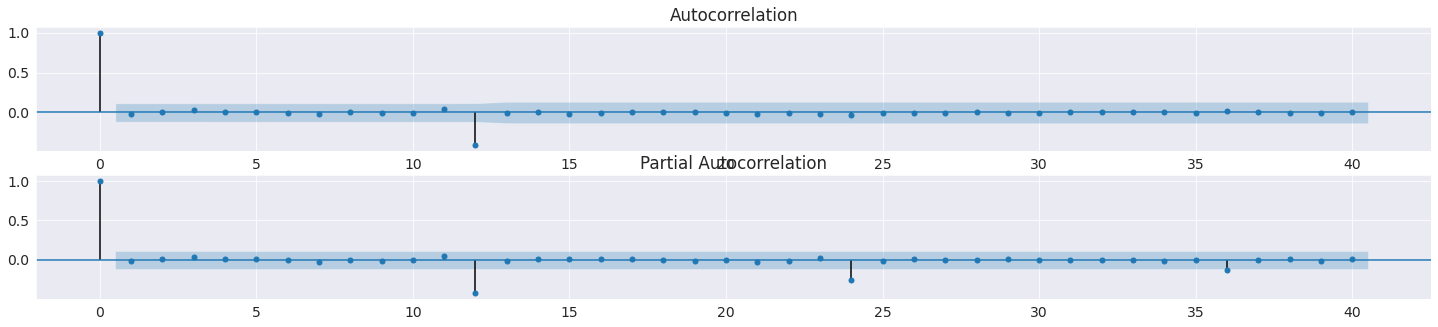

In [ ]:
# Autocorrelation analysis of residuals
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_011_311.resid.values, lags=40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_011_311.resid.values, lags=40, ax=ax2)

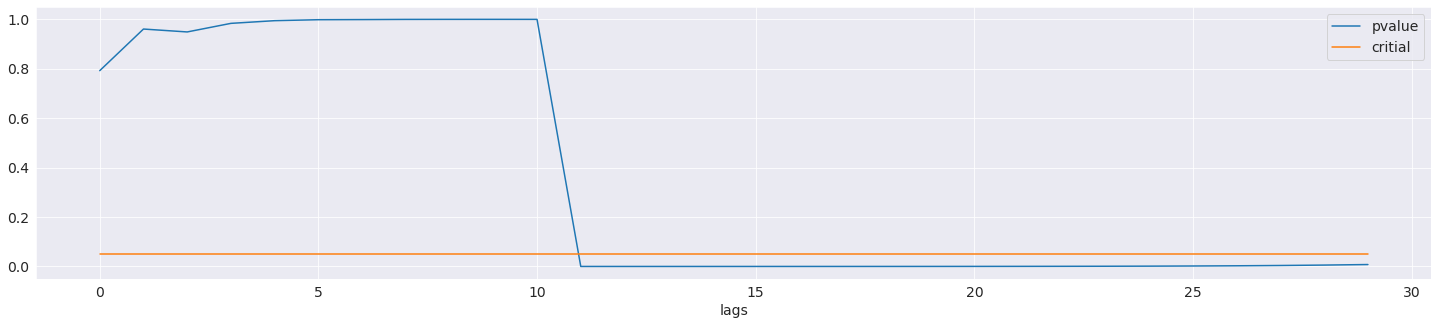

In [ ]:
# Ljung-Box test 
# H0: there is no correlcation for lag
pd.DataFrame({'lags':range(30), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(arima_011_311.resid.values, lags=30)[1], 
              'critial':np.array([0.05]*30)}).set_index('lags').plot()

It seems that LL lags for $\tau>12$ are correlated

# ARMA for forecasing Retail Time Series

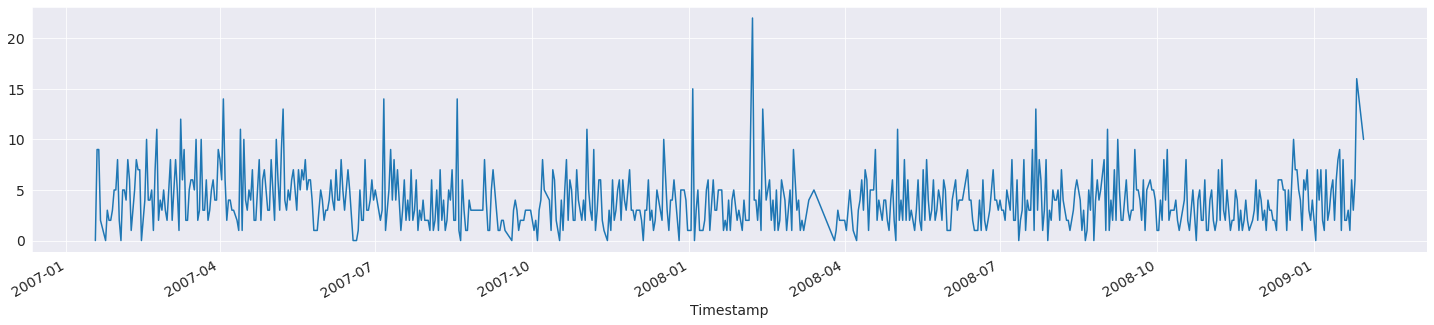

In [ ]:
ts = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_10ts.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index
# ts.head()
dta = ts[ts.columns[0]].dropna()
dta.plot()

It can be assumed that TS is stationary

**Question**
   * Select candidates for $p$ and $q$ values for ARMA model

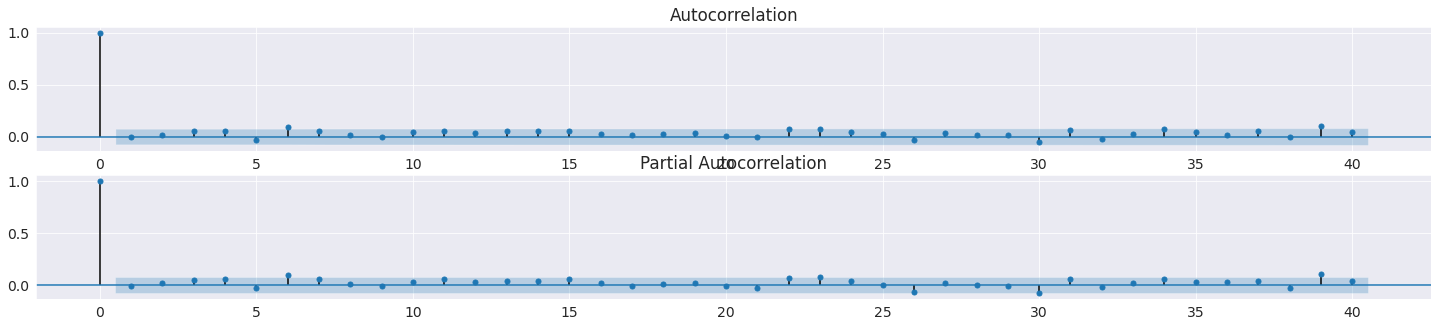

In [ ]:
# Use Item 165
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta.values.squeeze(), lags=40, ax=ax2)

Let's try 
* $q$ = {0, 6}
* $p$ = {0, 6}

In [ ]:
# ARMA (p=0, q=0)
arma_mod00 = sm.tsa.ARMA(dta, (0,0)).fit()
print(arma_mod00.params)
print(arma_mod00.llf,arma_mod00.aic, arma_mod00.bic, arma_mod00.hqic)

const    3.910819
dtype: float64
-1647.8191313253349 3299.6382626506697 3308.694178485915 3303.142639335463


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
# ARMA (p=0, q=6)
arma_mod06 = sm.tsa.ARMA(dta, (0,6)).fit()
print(arma_mod06.params)
print(arma_mod06.llf, arma_mod06.aic, arma_mod06.bic, arma_mod06.hqic)

const               3.916494
ma.L1.Item:  165   -0.014762
ma.L2.Item:  165    0.019738
ma.L3.Item:  165    0.050564
ma.L4.Item:  165    0.044455
ma.L5.Item:  165   -0.038893
ma.L6.Item:  165    0.099277
dtype: float64
-1642.3704844195888 3300.7409688391776 3336.964632180158 3314.7584755783523


In [ ]:
# ARMA (p=6, q=0)
arma_mod60 = sm.tsa.ARMA(dta, (6,0)).fit()
print(arma_mod60.params)
print(arma_mod60.llf, arma_mod60.aic, arma_mod60.bic, arma_mod60.hqic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


const               3.917924
ar.L1.Item:  165   -0.006394
ar.L2.Item:  165    0.014409
ar.L3.Item:  165    0.050951
ar.L4.Item:  165    0.058122
ar.L5.Item:  165   -0.031947
ar.L6.Item:  165    0.094291
dtype: float64
-1642.204847043037 3300.409694086074 3336.6333574270543 3314.4272008252487


In [1]:
# ARMA (p=6, q=6)
arma_mod66 = sm.tsa.ARMA(dta, (6,6)).fit()
print(arma_mod66.params)
print(arma_mod66.llf, arma_mod66.aic, arma_mod66.bic, arma_mod66.hqic)

### Analyse Residuals to proof the model

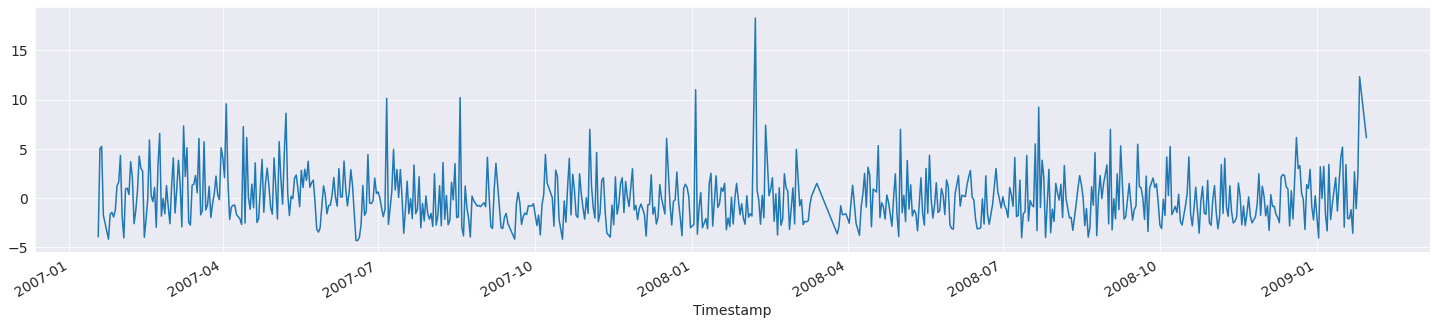

In [ ]:
# plot residuals
arma_mod06.resid.plot();

### Stationarity test

In [ ]:
# Kwiatkowski–Phillips–Schmidt–Shin
kpss_stat= stattools.kpss(arma_mod06.resid.values)
print('The KPSS test statistic %f, \npvalue: %.2f \nmaximal Lag: %i \ntable distribution: %s' % 
      (kpss_stat[0], kpss_stat[1], kpss_stat[2], kpss_stat[3]))

The KPSS test statistic 0.475620, 
pvalue: 0.05 
maximal Lag: 20 
table distribution: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


It can be assumed that TS is stationary

### Autocorrelation test

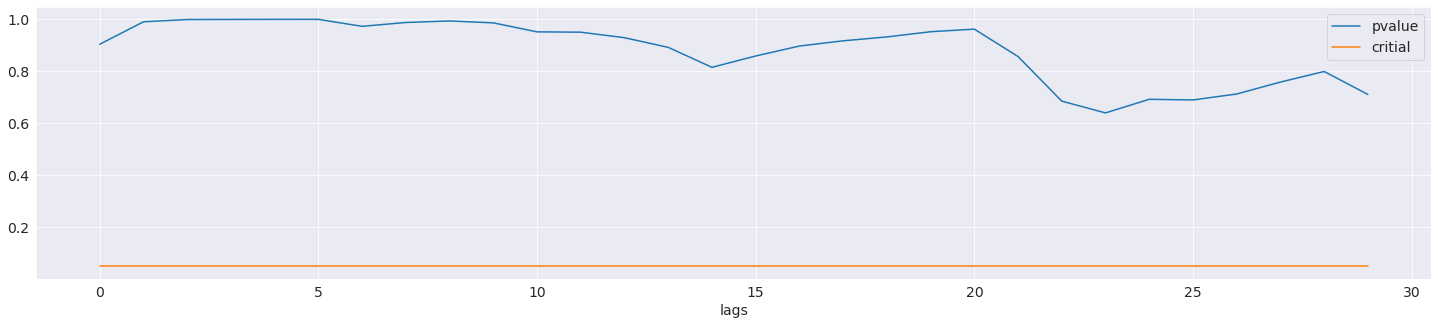

In [ ]:
# Ljung-Box test 
# H0: lags are not correlated
pd.DataFrame({'lags':range(30), 'pvalue':sm.stats.diagnostic.acorr_ljungbox(arma_mod06.resid.values, lags=30)[1], 
              'critial':np.array([0.05]*30)}).set_index('lags').plot()
# plt.plot(sm.stats.diagnostic.acorr_ljungbox(arma_mod00.resid.values, lags=30)[1],'b')

Values of the residuals TS are not correlated

In [ ]:
# Durbin_Watson statistic
# if there is no correlation in a sample then Stat ~= 2
sm.stats.durbin_watson(arma_mod06.resid.values)

1.9799781123277063

### Unbiasedness test

In [ ]:
# Wilcoxon test
# H0: obervations are not biased
stat, p = stats.wilcoxon(arma_mod06.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat, p))

Statistic: 104567.000000
pvalue: 0.02


Residuals are biased!

### Normality test

In [ ]:
stats.normaltest(arma_mod06.resid)

NormaltestResult(statistic=211.5149831946803, pvalue=1.1751815900585055e-46)

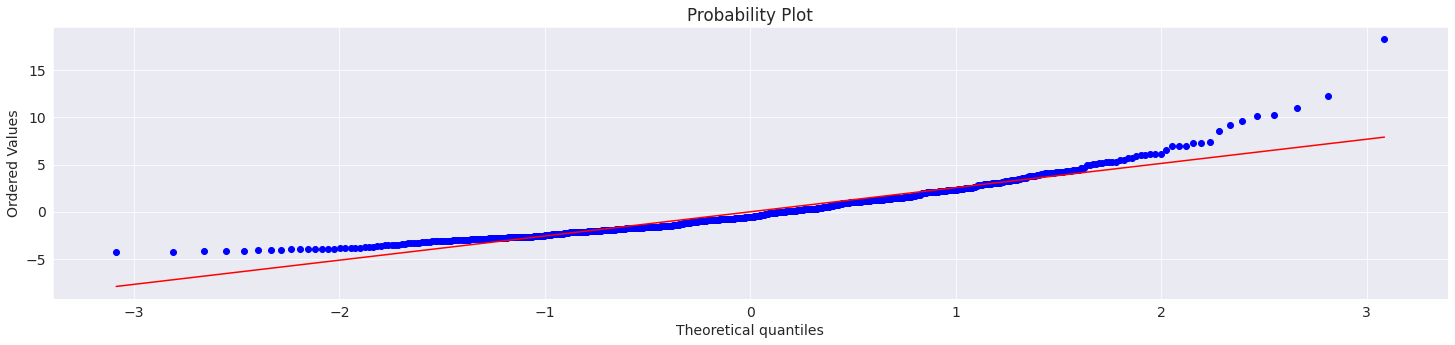

In [ ]:
## q-qPlot
fig = plt.figure()
res = stats.probplot(arma_mod06.resid, dist="norm", plot = plt)

* Hypothesis of normality can be rejected because of heavy tails of the real distribution 

### Forecast of Validation Period (in-sample)
Despite of theoretical issues of the built model we can generate forecast for the time series


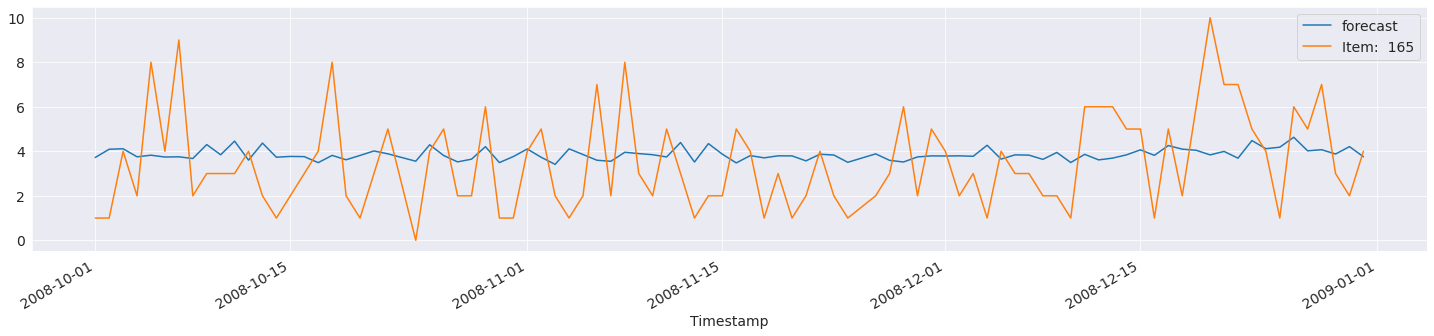

In [ ]:
# Static forecasting = one-step-ahead
fig, ax = plt.subplots()
fig = arma_mod06.plot_predict(start='2008-10-01', end='2008-12-31', ax=ax, dynamic=False)
# frc_arma = arma_mod06.predict('2008-12-30', '2008-12-31', dynamic=False)
# print(frc_arma)

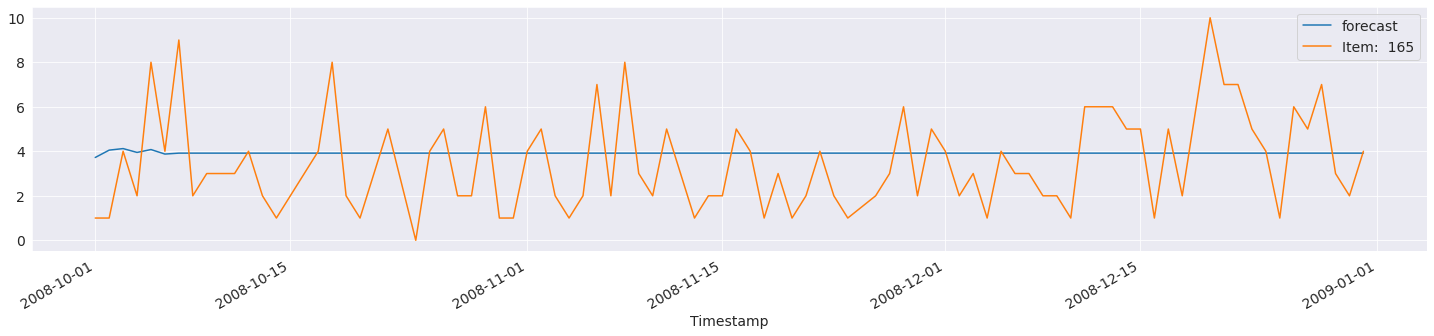

In [ ]:
# Dynamic forecasting = n-step-ahead
fig, ax = plt.subplots()
fig = arma_mod06.plot_predict(start='2008-10-01', end='2008-12-31', ax=ax, dynamic=True)
# print(frc_arma)

### Forecast of Future Period (out-of-sample)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


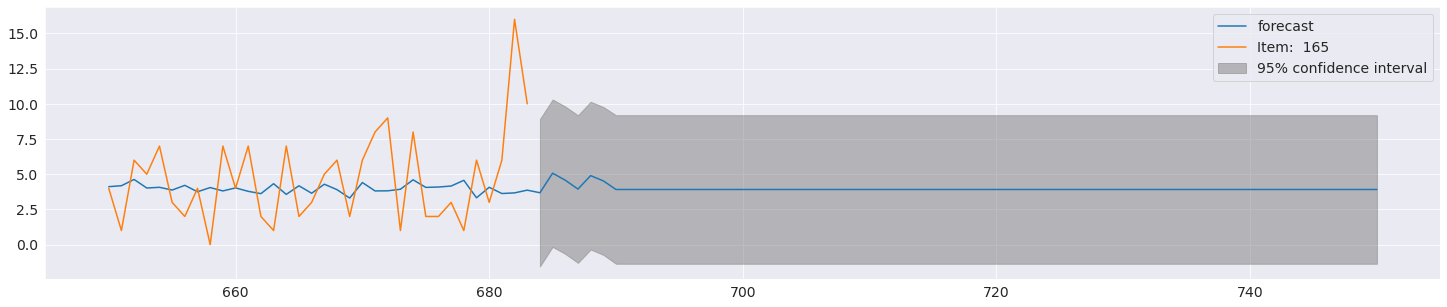

In [ ]:
# fig, ax = plt.subplots(figsize=(25,5),  linewidth=3.0)
fig = arma_mod06.plot_predict(650, 750)
# frc_arma = arma_mod06.forecast(steps=85)
# print(frc_arma[1])

# ACF anf PACF of ARIMA models

Example1 : ACF and PACF for AR(1) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/AR1.PNG?raw=1'>

Example2 : ACF and PACF for AR(2) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/AR2.PNG?raw=1'>


Example3 : ACF and PACF for AR(1) and MA(1) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/ARMA_1_1.PNG?raw=1'>



Example4 : ACF and PACF for MA(1) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/MA2_1.PNG?raw=1'>

<!-- 
Example5 : ACF and PACF for MA(2) model

<img src='https://github.com/aromanenko/ATSF/blob/main/pic/MA2_2.PNG?raw=1'> -->

# Online forecasting with ARIMA
Look how (even simple) ARIMA model performs in online aprroach 

In [ ]:
def online_ARMA(x, h, Params): # see statsmodels.ARMA
    
  # Параметры алгоритма
  p = Params['p']
  q = Params['q']

  rng = pd.date_range(x.index[-1]+timedelta(1),x.index[-1]+timedelta(h))
  frc_ts = pd.Series(index = x.index.append(rng))

  for t in x.index: #
      y = deepcopy(x.loc[:t])
      if not y.dropna().empty:
          try:
              arma_mod = sm.tsa.ARMA(y.dropna(), (p,q)).fit()
              frc_ts.loc[t+timedelta(h)] = arma_mod.forecast(h)[0][-1] # get last forecasting value
              # print(arma_mod.forecast(h)[0][-1])
          except Exception:
              print("Can not fit model p=%d, q=%d at step t=%s!" % (p, q, t))
  return frc_ts.ffill()

In [ ]:
# Caution: takes a lot of time
p = 0
q = 6
h = 1
ts_num = 1

frc_ts = online_ARMA(x=dta, h=h, Params={'p':p, 'q': q})

Can not fit model p=0, q=6 at step t=2007-01-18 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-19 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-20 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-21 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-24 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-25 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-26 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-27 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-28 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-29 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-30 00:00:00!
Can not fit model p=0, q=6 at step t=2007-01-31 00:00:00!
Can not fit model p=0, q=6 at step t=2007-02-01 00:00:00!
Can not fit model p=0, q=6 at step t=2007-02-02 00:00:00!
Can not fit model p=0, q=6 at step t=2007-02-03 00:00:00!
Can not fit model p=0, q=6 at step t=2007-02-04 00:00:00!
Can not fit model p=0, q=6 at step t=2007-02-05 00:00:00!
Can not fit mo

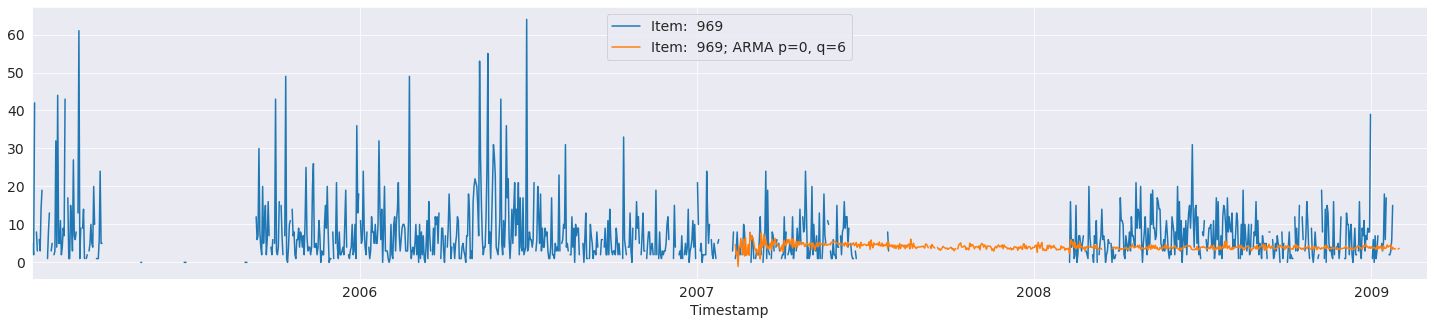

In [ ]:
# fair forecast by ARIMA model
plot_ts = ts[[ts.columns[ts_num]]]
# frc_ts = FRC_TS[Models[model]]
plot_ts["{0}; ARMA p={1}, q={2}".format(ts.columns[ts_num],p,q)] = frc_ts

plot_ts.plot() # :250

In [ ]:
plot_ts.iloc[:,0]

Timestamp
2005-01-11     2.0
2005-01-12     5.0
2005-01-13     2.0
2005-01-14    42.0
2005-01-15     NaN
              ... 
2009-02-26     NaN
2009-02-27     NaN
2009-02-28     NaN
2009-03-01     NaN
2009-03-02     NaN
Name: Item:  969, Length: 1512, dtype: float64

In [ ]:
# Quality 
print('MACAPE: %.2f'% qualityMACAPE(plot_ts.iloc[:,0], plot_ts.iloc[:,1])[0])
print('RMSE: %.1f'% qualityRMSE(ts[ts.columns[ts_num]], frc_ts[ts.columns[ts_num]])[0])

MACAPE: 0.50
RMSE: 3.9


# Conclusion
## Self-check questions
  1. How to define differencing order $d, D$ for a time series?
  2. What is autocorrelation function (ACF)?
  3. What does coefficient of correlation show?
  4. What is partial autocorrelation function (PACF)?  What does coefficient of partial correlation show?
  5. How do ACF and PACF help to choose $q, Q$ and $p, P$ of ARMA model?
   


**Materialsf**
* Автокорреляционный анализ при построении ARMA, ARIMA
    - Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
    - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model
    - А.И. Кобзарь. Прикладная математическая статистика. Для инженеров и научных работников http://zyurvas.narod.ru/knyhy2/Kobzar_Prikl_stat.djvu
* Autocorrelation analysis

  - https://online.stat.psu.edu/stat510/lesson/2

  - http://www.autobox.com/cms/index.php/blog/entry/build-or-make-your-own-arima-forecasting-model